In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import ipywidgets as widgets

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
training_data = datasets.MNIST(
    root="MNIST",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="MNIST",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.92MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 244kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [4]:
class VAE(nn.Module):
    def __init__(self,latent_dim=6):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 16),
            nn.ReLU()
        )
        

        self.fc_mu = nn.Linear(16, self.latent_dim)
        self.fc_log_sigma_sq = nn.Linear(16, self.latent_dim)


        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 7 * 7 * 64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() 
        )

    def reparameterize(self, mu, log_sigma_sq):
        std = torch.exp(0.5 * log_sigma_sq)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_sigma_sq = self.fc_log_sigma_sq(x)
        
        z = self.reparameterize(mu, log_sigma_sq)
        
        reconstruction = self.decoder(z)
        
        return reconstruction, mu, log_sigma_sq

In [5]:
def VAE_loss(data,output,mu,log_sigma_sq, beta):
    reconstruction = nn.BCELoss(reduction='sum')(output,data)/data.size(0)
    KLD = -0.5 * torch.sum(1+log_sigma_sq -mu**2 - torch.exp(log_sigma_sq),dim=1)
    return (reconstruction+beta*KLD.mean()) , reconstruction, beta*KLD.mean()

def sigmoid_annealing(current_step, total_annealing_steps, beta_max=3):
    return beta_max / (1 + np.exp(-12 * (current_step / total_annealing_steps - 0.5)))

In [6]:
model = VAE(latent_dim=6).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

In [ ]:
#model.load_state_dict(torch.load('weights.pth'))

<All keys matched successfully>

In [8]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False) 

In [9]:
epoch = 50
step = 0
max_step = 40

for i in range(epoch):
    j = 0
    for data, label in train_dataloader:
        optimizer.zero_grad()
        beta = sigmoid_annealing(step,max_step)
        data_flatten = data.to(device)
        output, mu, log_sigma_sq = model(data_flatten)
        loss, reconstruction_loss, KLD_loss = VAE_loss(data_flatten,output,mu,log_sigma_sq,beta)
        loss.backward()
        optimizer.step()
        if j%100==0:
            print("----------------------------------------------------------------------------------------")
            print(rf"epoch: {i}, j: {j}, β: {beta}, Loss: {loss}, r_loss: {reconstruction_loss}, KLD: {KLD_loss}")
            print("----------------------------------------------------------------------------------------")
            print(f"mu mean: {mu.mean().item():.3f}, std: {mu.std().item():.3f}")
            print(f"log_sigma_sq mean: {log_sigma_sq.mean().item():.3f}, std: {log_sigma_sq.std().item():.3f}")
        j+=1
    step+=1

----------------------------------------------------------------------------------------
epoch: 0, j: 0, β: 0.0074178694699043235, Loss: 100.27433013916016, r_loss: 100.19416809082031, KLD: 0.08016074448823929
----------------------------------------------------------------------------------------
mu mean: -0.058, std: 0.945
log_sigma_sq mean: -3.681, std: 0.422
----------------------------------------------------------------------------------------
epoch: 0, j: 100, β: 0.0074178694699043235, Loss: 99.75736236572266, r_loss: 99.62410736083984, KLD: 0.13325437903404236
----------------------------------------------------------------------------------------
mu mean: -0.125, std: 1.081
log_sigma_sq mean: -5.804, std: 0.523
----------------------------------------------------------------------------------------
epoch: 0, j: 200, β: 0.0074178694699043235, Loss: 95.46395874023438, r_loss: 95.31475830078125, KLD: 0.14920245110988617
------------------------------------------------------------

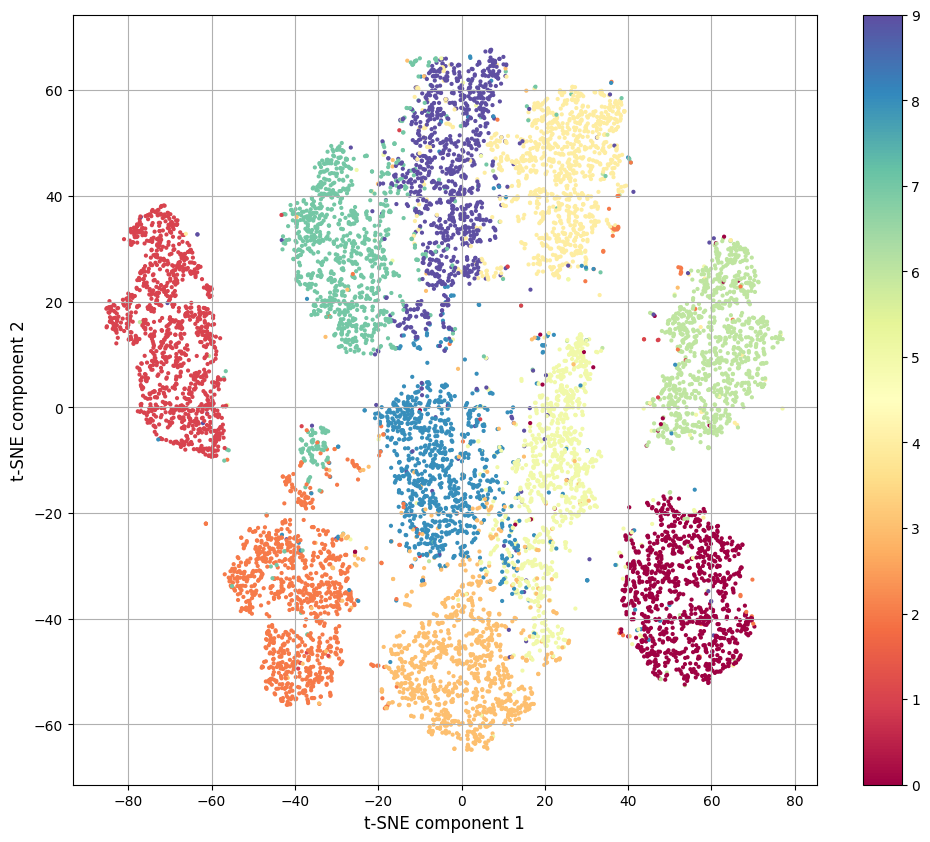

In [10]:
model.eval()

latent_vectors = []
labels = []
with torch.no_grad():
    for data, test_labels in test_dataloader:
        data = data.to(device)

        encoded_output = model.encoder(data)
        mu = model.fc_mu(encoded_output)

        latent_vectors.append(mu.cpu().numpy())
        labels.append(test_labels.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, perplexity=45, max_iter=1000, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)
plt.figure(figsize=(12, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='Spectral', s=4)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('t-SNE component 1', fontsize=12)
plt.ylabel('t-SNE component 2', fontsize=12)
plt.grid(True)
plt.show()

In [11]:
def plot_all_latent_dim(value, images_per_row,num_dimensions=model.latent_dim):
    num_rows = math.ceil(num_dimensions/images_per_row)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 5 * num_rows))

    if num_rows > 1:
        axes = axes.flatten()

    for i in range(num_dimensions):
        z = torch.zeros(1, num_dimensions).to(device)
        
        z[0, i] = value
        
        with torch.no_grad():
            generated = model.decoder(z)
            
        generated = generated.view(28, 28)
        
        img_array = generated.cpu().numpy()
        
        ax = axes[i]
        ax.imshow(img_array, cmap='gray')
        ax.set_title(f"z[{i}]={value}")
        ax.axis('off')


    plt.show()


def plot_single_latent_dim(index, max_value,images_per_row, num_dimensions = model.latent_dim):
    if not(0<=index<=num_dimensions-1):
        raise Exception(f"Index should be between 0 and {num_dimensions-1}, not {index}")
    
    num_img = max_value+1
    num_rows = math.ceil(num_img/images_per_row)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 5 * num_rows))

    if num_rows > 1:
        axes = axes.flatten()

    for i in range(num_img):
        z = torch.zeros(1, num_dimensions).to(device)
        
        z[0, index] = i
        
        with torch.no_grad():
            generated = model.decoder(z)
            
        generated = generated.view(28, 28)
        
        img_array = generated.cpu().numpy()
        
        ax = axes[i]
        ax.imshow(img_array, cmap='gray')
        ax.set_title(f"z[{index}]={i}")
        ax.axis('off')


    plt.show()

def interactive_latent_image(model=model, device=device, num_dimensions=6, min_range=-4,max_range=4):
    sliders_dict = {f"z{i}": widgets.FloatSlider(min=min_range, max=max_range, description=f"z{i}",orientation='vertical') for i in range(num_dimensions)}

    def generate_image(**kwargs):
        z_values = [kwargs[f"z{i}"] for i in range(num_dimensions)]
        z = torch.tensor(z_values, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            generated = model.decoder(z)
        generated = generated.view(28,28)
        img_array = generated.cpu().numpy()

        plt.figure(figsize=(12, 7))
        plt.imshow(img_array, cmap='gray')
        plt.axis('off')
        plt.title("Result")
        plt.show()

    slider_widgets = list(sliders_dict.values())
    ui = widgets.HBox(slider_widgets)

    out = widgets.interactive_output(generate_image, sliders_dict)

    display(ui, out)

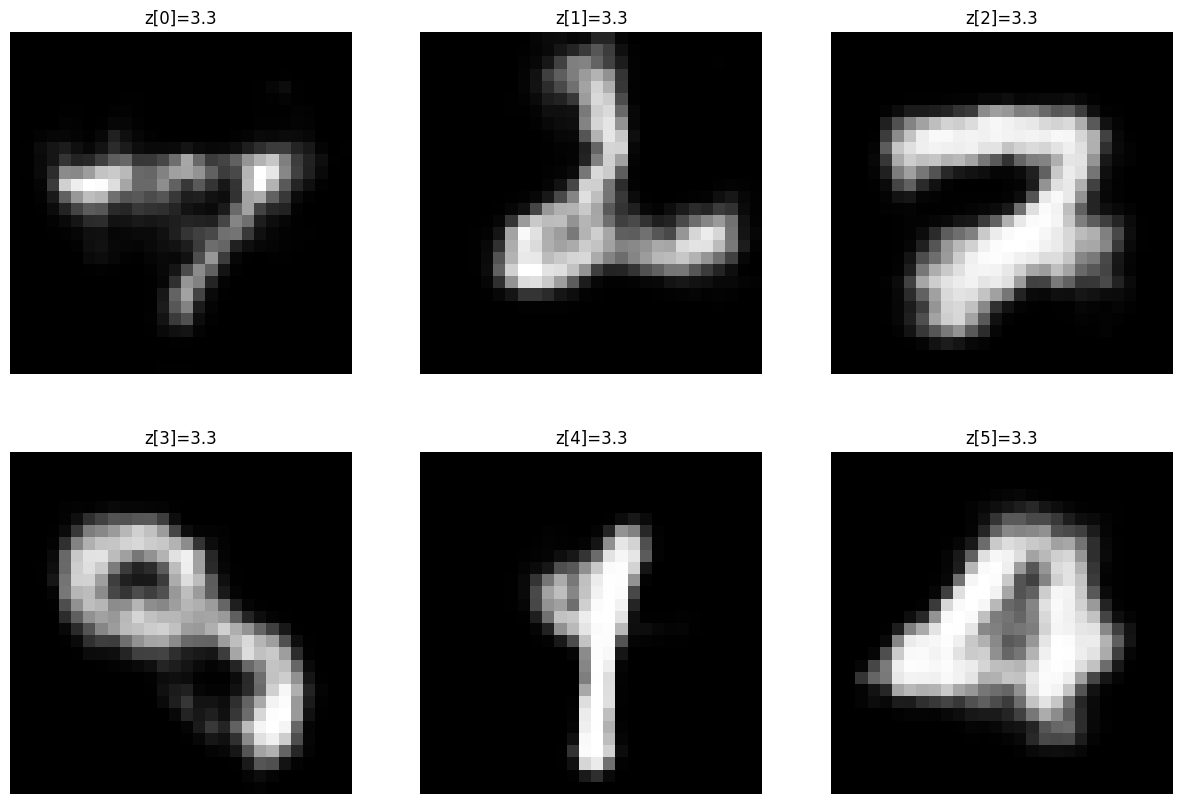

In [12]:
plot_all_latent_dim(3.3,3)

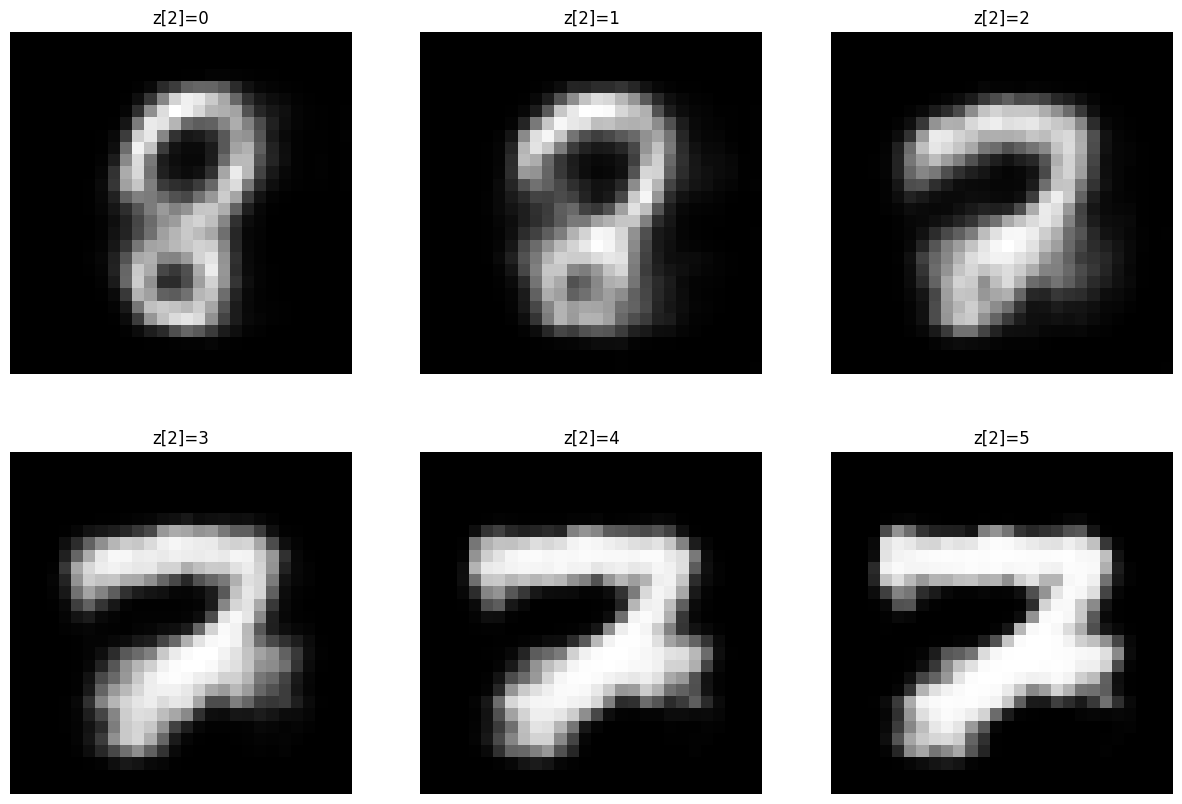

In [13]:
plot_single_latent_dim(2,5,3)

In [14]:
interactive_latent_image(model=model)

Output()